In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score

In [2]:
# load data
all_data = loadmat('data/sample_1.mat')
sample_data = np.array(all_data['data'])
spike_times = np.array(all_data['spike_times'])

In [3]:
# parameters
seconds = 1
sr = 24000 # 24kHz

data = sample_data[0][:round(seconds*sr)]
ground_truth_spikes = spike_times[0][0][0][:round(seconds*sr)]

mean_data = np.mean(data)
std_data = np.std(data)

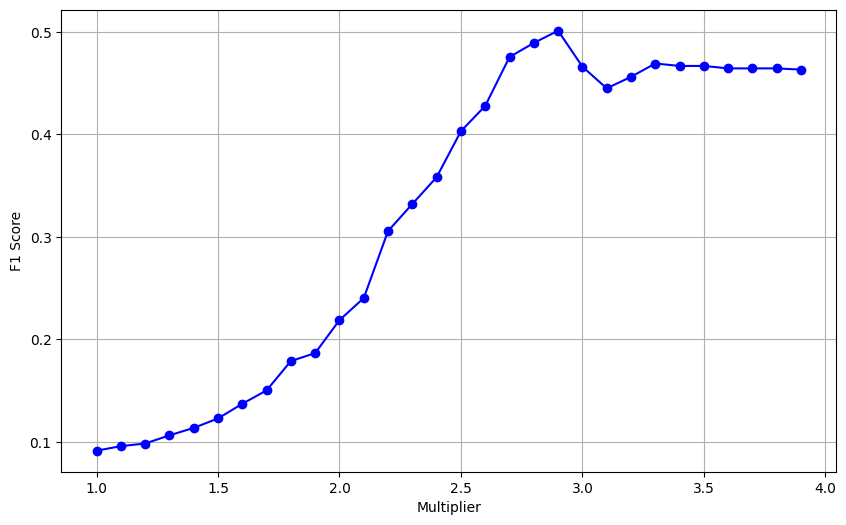

Best multiplier: 2.9000000000000017, F1 score: 0.5010162601626016


In [4]:
def detect_spikes(data, multiplier):
    spike_times_start_only = []
    spike_times_reconstructed = np.where(data >= np.mean(data) + multiplier * np.std(data))[0]
    
    if len(spike_times_reconstructed) > 0:
        spike_times_start_only.append(spike_times_reconstructed[0])
        spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

    return np.array(spike_times_start_only)


def calculate_f1_score(detected_spikes, ground_truth_spikes, sr, tolerance=0.001):
    # convert tolerance (time duration in seconds: 0.001 = 1ms) to number of samples
    tolerance_in_samples = tolerance * sr
    detected_binary = np.zeros_like(data)

    # set values to 1 where spikes occur (detected_binary[start_index:end_index] = 1)
    for spike in (detected_spikes / sr):
        detected_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    ground_truth_binary = np.zeros_like(data)
    for spike in (ground_truth_spikes / sr):
        ground_truth_binary[int(spike * sr - tolerance_in_samples): int(spike * sr + tolerance_in_samples)] = 1

    # calculate F1 score
    f1 = f1_score(ground_truth_binary, detected_binary)
    
    return f1

# test different multiplier values for threshold
multipliers = np.arange(1.0, 4.0, 0.1) 
f1_scores = []

for multiplier in multipliers:
    detected_spikes = detect_spikes(data, multiplier)
    f1 = calculate_f1_score(detected_spikes, spike_times[0][0][0][:round(seconds*sr)], sr)
    f1_scores.append(f1)

# plot F1 scores as a function of the multiplier
plt.figure(figsize=(10, 6))
plt.plot(multipliers, f1_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Multiplier')
plt.ylabel('F1 Score')
plt.grid()
plt.show()

# get best multiplier based on F1 score
best_f1 = max(f1_scores)
best_multiplier = multipliers[np.argmax(f1_scores)]
print(f"Best multiplier: {best_multiplier}, F1 score: {best_f1}")

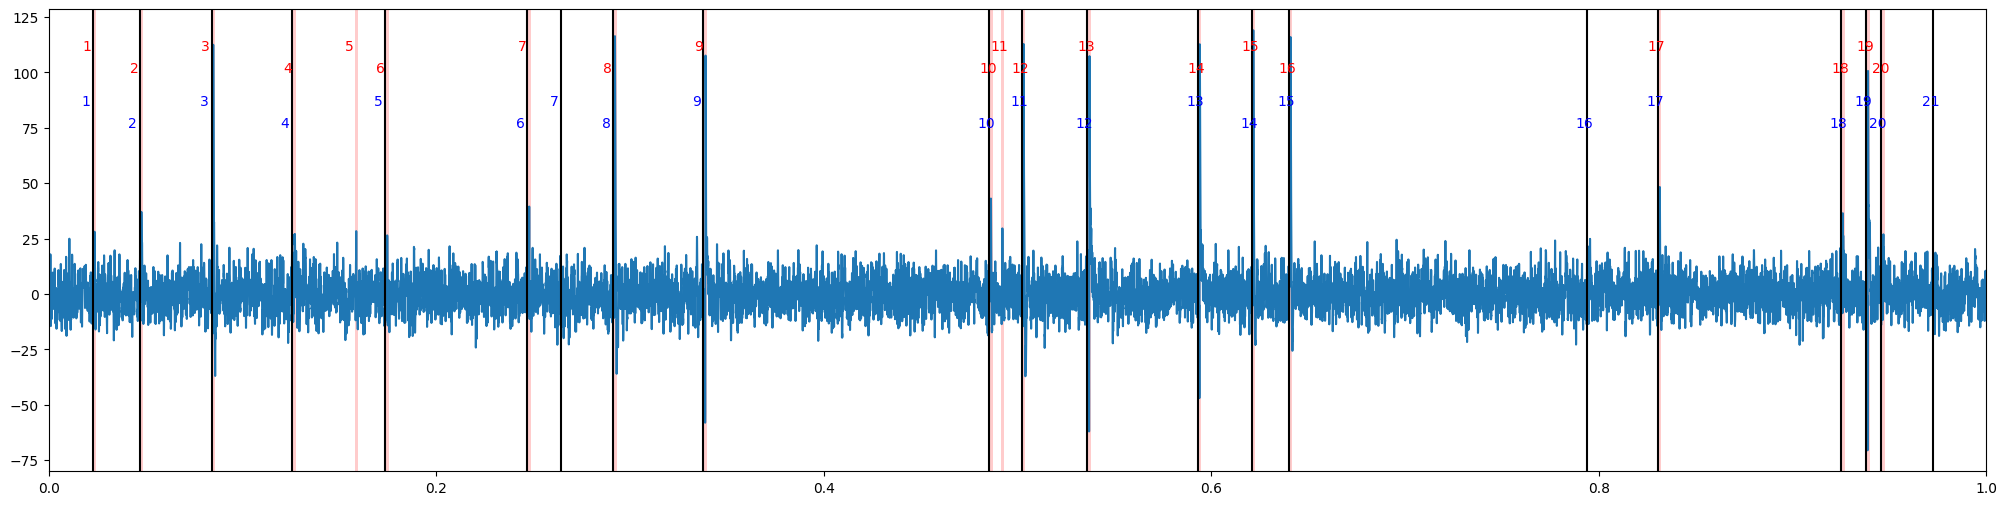

In [5]:
# display data
plt.figure(figsize=(25,6))
plt.plot(np.linspace(0, seconds, round(seconds*sr)), data)
plt.xlim(0, seconds)

spike_times_reconstructed = np.where(data >= mean_data + best_multiplier * std_data)[0]
spike_times_start_only = []
spike_times_start_only.append(spike_times_reconstructed[0])
spike_times_start_only.extend(spike_times_reconstructed[np.where(np.diff(spike_times_reconstructed) > 10)[0]+1])

for i, spike in enumerate(spike_times_start_only):
    # plt.axvline(spike/sr - .0008, c='red', alpha=0.5)
    plt.axvspan(spike/sr - .0008, spike/sr + .001, facecolor='r', alpha=0.2)
    plt.text(spike/sr - 0.006, 110 if i%2 == 0 else 100, i+1, c='r')
    
for i, spike in enumerate(ground_truth_spikes / sr):
    if round(spike*24000) > round(seconds*24000): break
    plt.axvline(spike, c='k', alpha=1)
    plt.text(spike - 0.006, 85 if i%2 == 0 else 75, i+1, c='b')
    
plt.show()

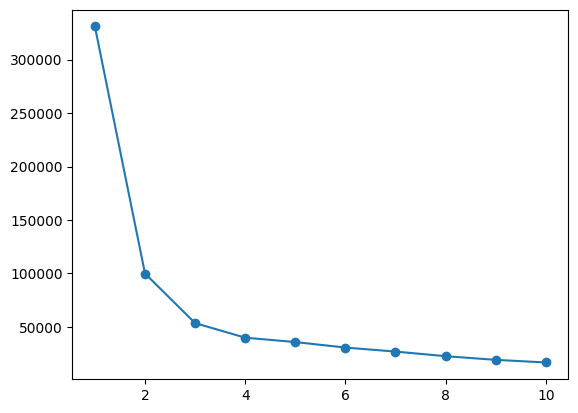

In [6]:
number_of_spikes = len(spike_times_start_only)

ymax = 0
ymin = 0
spikes = []
for spike in spike_times_start_only:
    start = round(spike - .0008 * sr)
    end = round(spike + .001 * sr)
    if np.max(data[start:end]) > ymax: ymax = np.max(data[start:end])
    if np.min(data[start:end]) < ymin: ymin = np.min(data[start:end])
    spikes.append(data[start:end])

inertias = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init='auto')
    kmeans.fit(spikes)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.show()


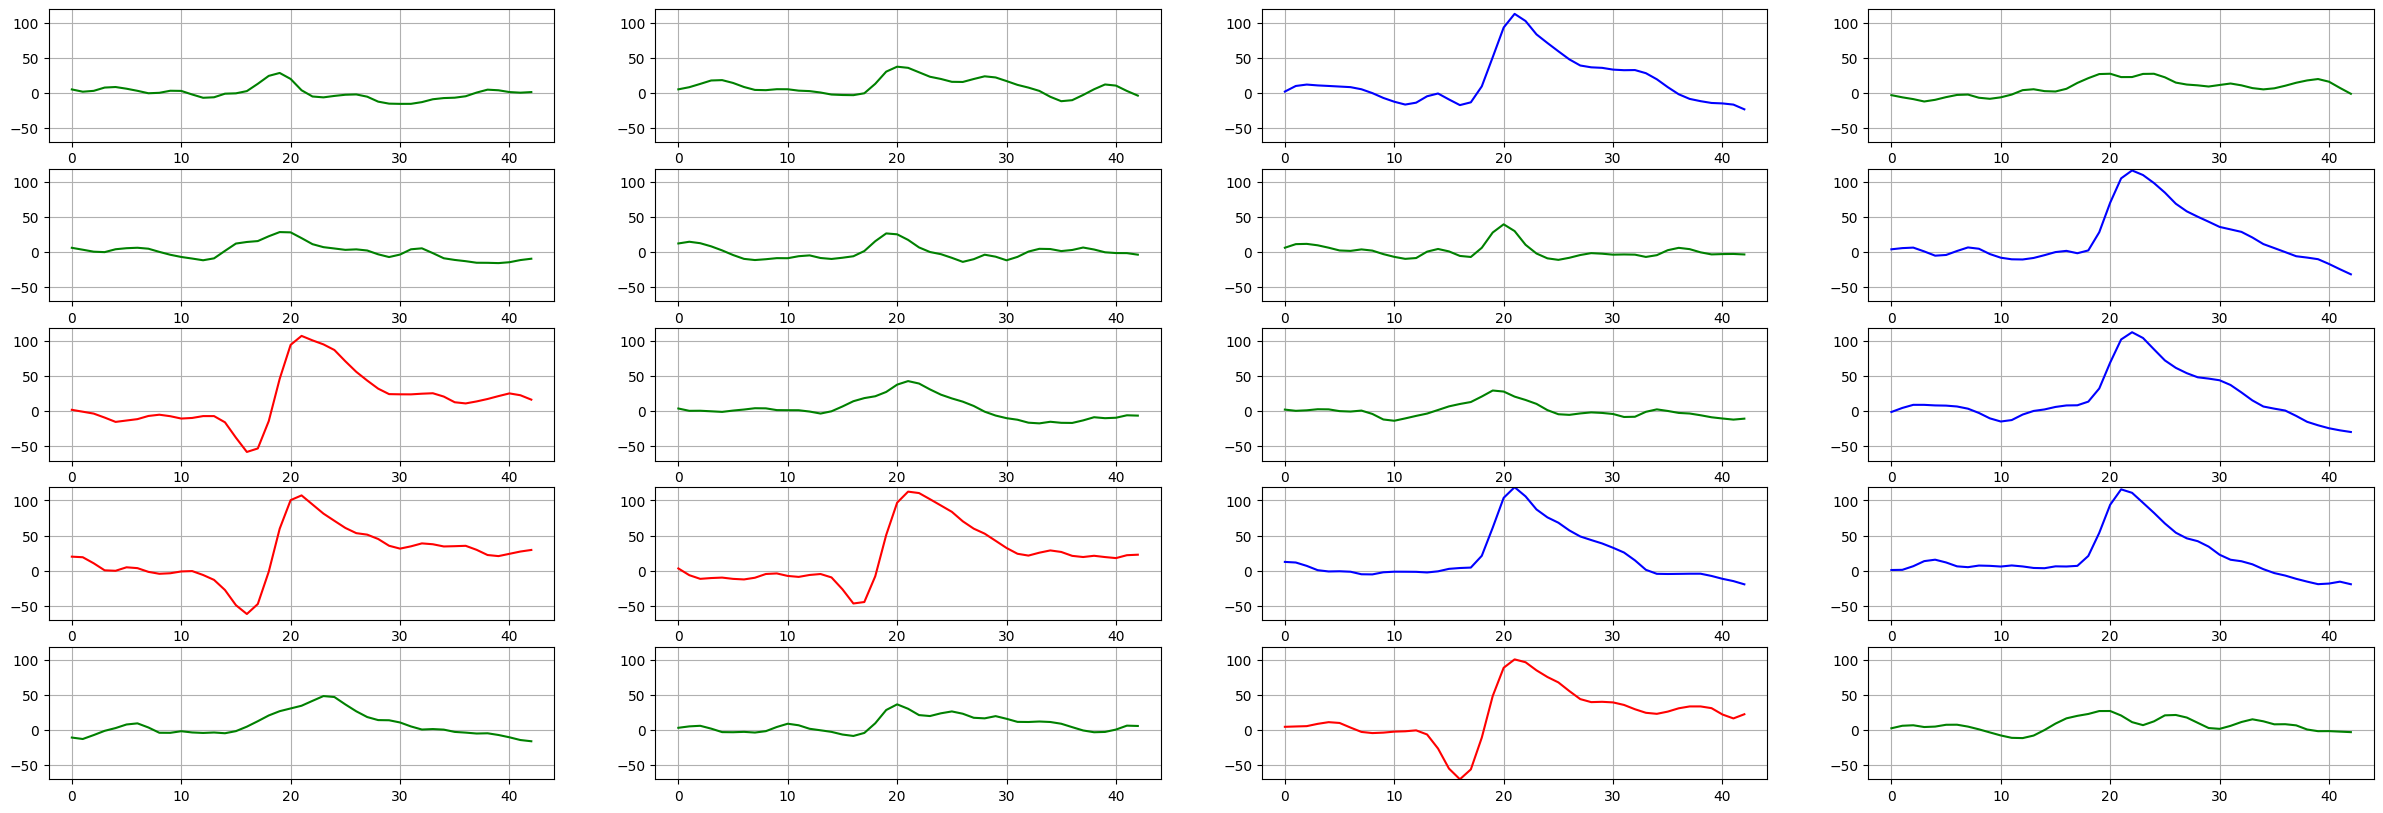

In [7]:
plt.figure(figsize=(30,10))

kmeans_final = KMeans(n_init='auto', n_clusters=3)
classes = kmeans_final.fit_predict(spikes)
colors = ['r', 'g', 'b', 'orange']

for i, spike in enumerate(spike_times_start_only):
    start = round(spike - .0008 * sr)
    end = round(spike + .001 * sr)
    plt.subplot(5, math.ceil(number_of_spikes/5), i+1)
    plt.grid()
    plt.ylim(ymin, ymax)
    plt.plot(data[start:end], c=colors[classes[i]])
plt.show()